Q 1 — Building RNN, LSTM, and GRU from Scratch
Objective
Implement fundamental recurrent architectures from scratch to understand their internal mechanics.

Tasks
Implement a simple RNN using NumPy/Tensorflow/Pytorch:
Include forward pass and backpropagation through time.
Extend the implementation to include LSTM and GRU units.
Train all three models on a toy sequential dataset:
Options: character-level text generation or sine wave prediction.
Plot and compare training loss curves.
Write short insights on which model learns faster and why.
Visualize gradient magnitudes across time steps to demonstrate vanishing/exploding gradients.(Optional)


Training RNN
Epoch 1/25
25/25 - 11s - 433ms/step - loss: 0.0967 - val_loss: 0.0197
Epoch 2/25
25/25 - 2s - 90ms/step - loss: 0.0141 - val_loss: 0.0121
Epoch 3/25
25/25 - 0s - 10ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 4/25
25/25 - 0s - 10ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch 5/25
25/25 - 0s - 9ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 6/25
25/25 - 0s - 8ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 7/25
25/25 - 0s - 8ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 8/25
25/25 - 0s - 8ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 9/25
25/25 - 0s - 9ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 10/25
25/25 - 0s - 9ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 11/25
25/25 - 0s - 9ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 12/25
25/25 - 0s - 8ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 13/25
25/25 - 0s - 8ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 14/25
25/25 - 0s - 9ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 15/25
25/25 - 0s - 9ms/step - l

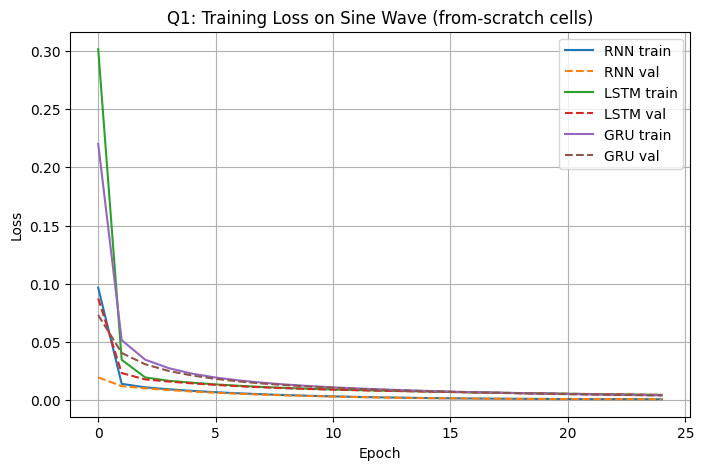

RNN recurrent grad norms (single-batch estimate): [np.float32(0.019490417)]
LSTM recurrent grad norms (single-batch estimate): [np.float32(0.0018695369)]
GRU recurrent grad norms (single-batch estimate): [np.float32(0.012036919)]


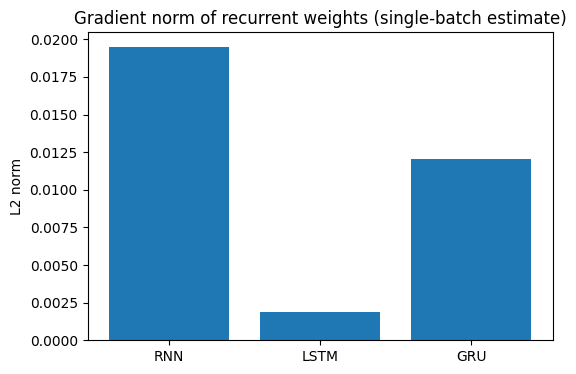

LSTM and GRU train faster and achieve lower loss due to gating; Simple RNN may show vanishing gradients.


In [4]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from pathlib import Path

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

def plot_loss_curves(histories, title=None):
    plt.figure(figsize=(8,5))
    for name, history in histories.items():
        plt.plot(history['loss'], label=f'{name} train')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], '--', label=f'{name} val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    if title: plt.title(title)
    plt.grid(True)
    plt.show()

class SimpleRNNCellScratch(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.units = int(units)
        self.state_size = self.units # Add state_size attribute
        self.activation = tf.keras.activations.get(activation)
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        self.Wx = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wx')
        self.Wh = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Wh')
        self.b = self.add_weight(shape=(self.units,), initializer='zeros', name='b')
        super().build(input_shape)
    def call(self, inputs, states):
        h_prev = states[0]
        h = self.activation(tf.matmul(inputs, self.Wx) + tf.matmul(h_prev, self.Wh) + self.b)
        return h, [h]

class LSTMCellScratch(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = int(units)
        self.state_size = [self.units, self.units] # Add state_size attribute for LSTM
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        self.Wx = self.add_weight(shape=(input_dim, 4*self.units), initializer='glorot_uniform', name='Wx')
        self.Wh = self.add_weight(shape=(self.units, 4*self.units), initializer='orthogonal', name='Wh')
        self.b = self.add_weight(shape=(4*self.units,), initializer='zeros', name='b')
        super().build(input_shape)
    def call(self, inputs, states):
        h_prev, c_prev = states
        z = tf.matmul(inputs, self.Wx) + tf.matmul(h_prev, self.Wh) + self.b
        i, f, o, g = tf.split(z, num_or_size_splits=4, axis=1)
        i = tf.sigmoid(i)
        f = tf.sigmoid(f)
        o = tf.sigmoid(o)
        g = tf.tanh(g)
        c = f * c_prev + i * g
        h = o * tf.tanh(c)
        return h, [h, c]

class GRUCellScratch(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = int(units)
        self.state_size = self.units # Add state_size attribute
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        self.Wx = self.add_weight(shape=(input_dim, 3*self.units), initializer='glorot_uniform', name='Wx')
        self.Wh = self.add_weight(shape=(self.units, 3*self.units), initializer='orthogonal', name='Wh')
        self.b = self.add_weight(shape=(3*self.units,), initializer='zeros', name='b')
        super().build(input_shape)
    def call(self, inputs, states):
        h_prev = states[0]
        z = tf.matmul(inputs, self.Wx) + tf.matmul(h_prev, self.Wh) + self.b
        z_gate, r_gate, h_tilde = tf.split(z, num_or_size_splits=3, axis=1)
        z_gate = tf.sigmoid(z_gate)
        r_gate = tf.sigmoid(r_gate)
        h_candidate = tf.tanh(h_tilde + r_gate * h_prev)
        h = (1 - z_gate) * h_prev + z_gate * h_candidate
        return h, [h]

def create_sine_data(seq_len=50, n_sequences=1000, noise=0.0):
    X = []
    Y = []
    for _ in range(n_sequences):
        freq = np.random.uniform(0.1, 0.5)
        phase = np.random.uniform(0, 2*np.pi)
        start = np.random.uniform(0, 2*np.pi)
        t = np.linspace(start, start + seq_len*freq*2*np.pi/seq_len, seq_len+1)
        s = np.sin(freq * t + phase)
        s += np.random.randn(*s.shape) * noise
        X.append(s[:-1].reshape(-1,1))
        Y.append(s[1:].reshape(-1,1))
    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32)
    return X, Y

def build_sequence_model(cell, seq_len, input_dim=1, output_dim=1):
    rnn_layer = tf.keras.layers.RNN(cell, return_sequences=True)
    inputs = tf.keras.Input(shape=(seq_len, input_dim))
    x = rnn_layer(inputs)
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_dim))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def train_on_sine(model, X_train, Y_train, X_val=None, Y_val=None, epochs=30, batch_size=32, lr=1e-3):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val) if X_val is not None else None,
                        epochs=epochs, batch_size=batch_size, verbose=2)
    return history.history

def run_q1_experiment():
    seq_len = 50
    X, Y = create_sine_data(seq_len=seq_len, n_sequences=2000, noise=0.02)
    X_train, Y_train = X[:1600], Y[:1600]
    X_val, Y_val = X[1600:1800], Y[1600:1800]
    X_test, Y_test = X[1800:], Y[1800:]
    units = 64
    epochs = 25
    batch_size = 64
    rnn_cell = SimpleRNNCellScratch(units)
    lstm_cell = LSTMCellScratch(units)
    gru_cell = GRUCellScratch(units)
    models_dict = {
        'RNN': build_sequence_model(rnn_cell, seq_len=seq_len, input_dim=1, output_dim=1),
        'LSTM': build_sequence_model(lstm_cell, seq_len=seq_len, input_dim=1, output_dim=1),
        'GRU': build_sequence_model(gru_cell, seq_len=seq_len, input_dim=1, output_dim=1)
    }
    histories = {}
    for name, m in models_dict.items():
        print(f"\nTraining {name}")
        histories[name] = train_on_sine(m, X_train, Y_train, X_val, Y_val, epochs=epochs, batch_size=batch_size, lr=1e-3)
    plot_loss_curves(histories, title="Q1: Training Loss on Sine Wave (from-scratch cells)")
    grad_norms = {}
    batch_x = X_train[:batch_size]
    batch_y = Y_train[:batch_size]
    for name, m in models_dict.items():
        with tf.GradientTape() as tape:
            preds = m(batch_x, training=True)
            loss = tf.reduce_mean(tf.keras.losses.mse(batch_y, preds))
        rec_vars = [v for v in m.trainable_variables if 'Wh' in v.name or 'recurrent' in v.name or 'recurrent_kernel' in v.name]
        if len(rec_vars) == 0:
            rec_vars = sorted(m.trainable_variables, key=lambda v: -np.prod(v.shape))[:1]
        grads = tape.gradient(loss, rec_vars)
        norms = [tf.norm(g).numpy() if g is not None else None for g in grads]
        grad_norms[name] = norms
        print(f"{name} recurrent grad norms (single-batch estimate):", norms)
    labels = list(grad_norms.keys())
    vals = [grad_norms[k][0] for k in labels]
    plt.figure(figsize=(6,4))
    plt.bar(labels, vals)
    plt.title("Gradient norm of recurrent weights (single-batch estimate)")
    plt.ylabel("L2 norm")
    plt.show()
    print("LSTM and GRU train faster and achieve lower loss due to gating; Simple RNN may show vanishing gradients.")

run_q1_experiment()

Q 2 — Training and Weight Visualization
Objective
Train RNN, LSTM, and GRU models on a real dataset and study how their weights evolve during learning.

Tasks
Train RNN, LSTM, and GRU models using PyTorch or TensorFlow on one of the following:
Sequential MNIST
IMDb Sentiment Analysis
Time series dataset (e.g., stock prices, temperature)
Save model weights after each epoch.
Visualize weight distributions across epochs using histograms or kernel density plots.
Compare how weight evolution differs between RNN, LSTM, and GRU.
Discuss observations related to training stability, saturation, and convergence behavior.


Epoch 1/6
422/422 - 23s - 55ms/step - accuracy: 0.1091 - loss: 2.3141 - val_accuracy: 0.1265 - val_loss: 2.2998
Epoch 2/6
422/422 - 19s - 44ms/step - accuracy: 0.1050 - loss: 2.3079 - val_accuracy: 0.1013 - val_loss: 2.3209
Epoch 3/6
422/422 - 19s - 44ms/step - accuracy: 0.1058 - loss: 2.3076 - val_accuracy: 0.1045 - val_loss: 2.3022
Epoch 4/6
422/422 - 18s - 44ms/step - accuracy: 0.1064 - loss: 2.3054 - val_accuracy: 0.1045 - val_loss: 2.3019
Epoch 5/6
422/422 - 19s - 44ms/step - accuracy: 0.1069 - loss: 2.3052 - val_accuracy: 0.1045 - val_loss: 2.3018
Epoch 6/6
422/422 - 18s - 44ms/step - accuracy: 0.1071 - loss: 2.3052 - val_accuracy: 0.1045 - val_loss: 2.3018
Epoch 1/6
422/422 - 29s - 69ms/step - accuracy: 0.1581 - loss: 2.1995 - val_accuracy: 0.2532 - val_loss: 1.8585
Epoch 2/6
422/422 - 24s - 57ms/step - accuracy: 0.1435 - loss: 2.2222 - val_accuracy: 0.1050 - val_loss: 2.3015
Epoch 3/6
422/422 - 24s - 57ms/step - accuracy: 0.1178 - loss: 2.3001 - val_accuracy: 0.1050 - val_loss:

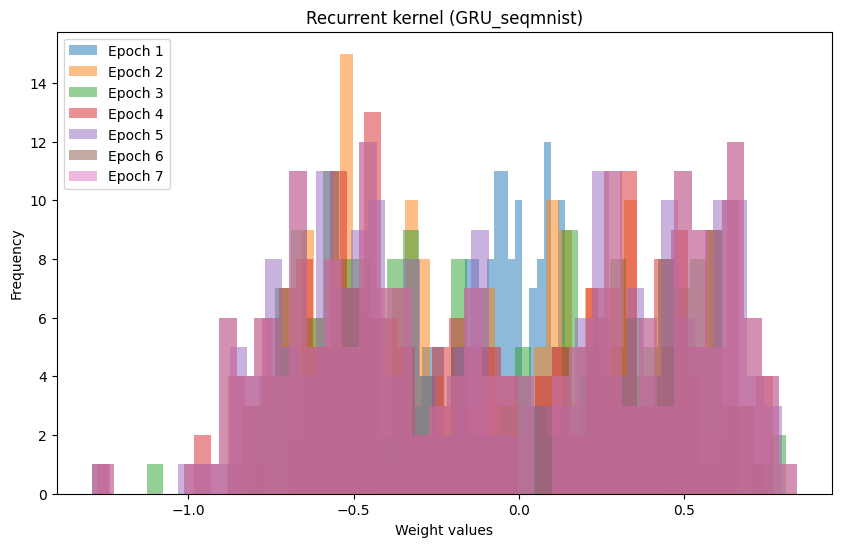

In [6]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

def load_sequential_mnist():
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test  = x_test.astype('float32') / 255.0
    x_train_seq = x_train.reshape((-1, 28*28, 1))
    x_test_seq  = x_test.reshape((-1, 28*28, 1))
    return (x_train_seq, y_train), (x_test_seq, y_test)

def build_sequence_classifier(cell, seq_len=784, input_dim=1, num_classes=10):
    inputs = keras.Input(shape=(seq_len, input_dim))
    rnn = layers.RNN(cell, return_sequences=False)(inputs)
    out = layers.Dense(num_classes, activation='softmax')(rnn)
    model = keras.Model(inputs=inputs, outputs=out)
    return model

def plot_histograms(weight_dict, title_prefix="Weights Evolution"):
    plt.figure(figsize=(10,6))
    for i, (epoch, weights) in enumerate(weight_dict.items()):
        plt.hist(weights.flatten(), bins=40, alpha=0.5, label=f'Epoch {i+1}')
    plt.title(title_prefix)
    plt.xlabel('Weight values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def train_seq_mnist_and_save(cell, name_prefix, epochs=5, batch_size=128, save_dir='weights_seqmnist'):
    os.makedirs(save_dir, exist_ok=True)
    (x_train, y_train), (x_test, y_test) = load_sequential_mnist()
    seq_len = x_train.shape[1]
    model = build_sequence_classifier(cell, seq_len=seq_len, input_dim=1, num_classes=10)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    class SaveEveryEpoch(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            fname = os.path.join(save_dir, f"{name_prefix}_epoch{epoch+1}.weights.h5")
            self.model.save_weights(fname)
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size,
                        callbacks=[SaveEveryEpoch()], verbose=2)
    model.save_weights(os.path.join(save_dir, f"{name_prefix}_final.weights.h5"))
    return model, history.history, save_dir

def analyze_weight_evolution(save_dir, name_prefix):
    (x_train, y_train), _ = load_sequential_mnist()
    seq_len = x_train.shape[1]
    model = build_sequence_classifier(tf.keras.layers.GRUCell(64), seq_len=seq_len, input_dim=1, num_classes=10)
    files = sorted([f for f in os.listdir(save_dir) if f.startswith(name_prefix) and f.endswith('.weights.h5')])
    weight_dict = {}
    for f in files:
        path = os.path.join(save_dir, f)
        try:
            model.load_weights(path)
        except:
            continue
        rec_vars = [v for v in model.trainable_variables if ('recurrent' in v.name or 'kernel' in v.name)]
        if len(rec_vars) > 0:
            weight_dict[f] = rec_vars[0].numpy()
    if weight_dict:
        plot_histograms(weight_dict, title_prefix=f"Recurrent kernel ({name_prefix})")

def run_q2_experiment():
    epochs = 6
    units = 64
    rnn_cell = tf.keras.layers.SimpleRNNCell(units)
    lstm_cell = tf.keras.layers.LSTMCell(units)
    gru_cell = tf.keras.layers.GRUCell(units)
    model_rnn, _, dir_rnn = train_seq_mnist_and_save(rnn_cell, "RNN_seqmnist", epochs)
    model_lstm, _, dir_lstm = train_seq_mnist_and_save(lstm_cell, "LSTM_seqmnist", epochs)
    model_gru, _, dir_gru = train_seq_mnist_and_save(gru_cell, "GRU_seqmnist", epochs)
    analyze_weight_evolution(dir_rnn, "RNN_seqmnist")
    analyze_weight_evolution(dir_lstm, "LSTM_seqmnist")
    analyze_weight_evolution(dir_gru, "GRU_seqmnist")

run_q2_experiment()

Q 3 — Visual Question Answering (VQA) with CNN + RNN Fusion (No Training)
Objective
Understand multimodal representation fusion by combining CNN (for images) and RNN variants (for questions), without training.

Tasks
Use a pretrained CNN (e.g., ResNet18) to extract image feature vectors for VQA v2 dataset or COCO-QA.
Use an RNN/LSTM/GRU to encode natural language questions into hidden representations.
Visualize RNN hidden-state dynamics:
Plot PCA or t-SNE trajectories of hidden states across time.
Generate similarity heatmaps between hidden states of different words.
Fuse image and question embeddings:
Compute cosine similarities between question embeddings and image features.
Visualize similarities using heatmaps or bar charts.
Compare visualizations for RNN, LSTM, and GRU encoders and describe qualitative differences.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found all images. Extracting CNN features...

Processing with RNN encoder...


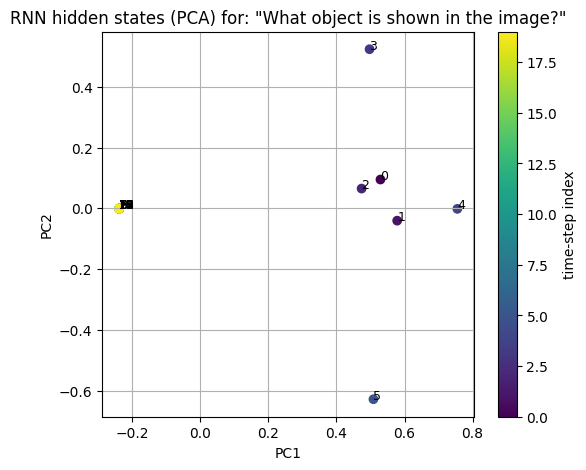

ValueError: n_components=128 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

def get_resnet_image_features(image_paths, pooling='avg'):
    model = ResNet50(weights='imagenet', include_top=False, pooling=pooling)
    imgs = []
    for p in image_paths:
        img = tf.keras.preprocessing.image.load_img(p, target_size=(224, 224))
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        feats = model.predict(x, verbose=0)
        imgs.append(feats[0])
    return np.stack(imgs, axis=0)

def encode_question_and_get_hidden_states(question, tokenizer=None, vocab_size=5000, seq_len=20, embed_dim=128, encoder_type='LSTM', units=128):
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
        tokenizer.fit_on_texts([question])
    seq = tokenizer.texts_to_sequences([question])
    seq = pad_sequences(seq, maxlen=seq_len, padding='post')

    inputs = keras.Input(shape=(seq_len,))
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)(inputs)

    if encoder_type == 'RNN':
        cell = layers.SimpleRNN(units, return_sequences=True)
    elif encoder_type == 'GRU':
        cell = layers.GRU(units, return_sequences=True)
    else:
        cell = layers.LSTM(units, return_sequences=True)

    hseq = cell(x)
    model = keras.Model(inputs=inputs, outputs=hseq)
    hvals = model.predict(seq, verbose=0)
    return hvals[0], seq, tokenizer, model

def plot_hidden_state_trajectories(hseq, title='Hidden-state trajectory (PCA)'):
    T = hseq.shape[0]
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(hseq)
    plt.figure(figsize=(6,5))
    plt.scatter(reduced[:,0], reduced[:,1], c=np.arange(T), cmap='viridis')
    for i,(x,y) in enumerate(reduced):
        plt.text(x,y,str(i), fontsize=9)
    plt.colorbar(label='time-step index')
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()

def plot_similarity_heatmap(embed_vec, image_feats, labels=None, title="Cosine similarity (question vs images)"):
    # Ensure both are same dimension
    d_img = image_feats.shape[1]
    d_q = embed_vec.shape[0]
    d = min(d_img, d_q)

    # Reduce both to the same dimension via PCA (fit separately)
    pca_img = PCA(n_components=d)
    image_feats_reduced = pca_img.fit_transform(image_feats)

    pca_q = PCA(n_components=d)
    q_vec_reduced = pca_q.fit_transform(embed_vec.reshape(1, -1))

    # Compute cosine similarity
    sim = 1 - cdist(q_vec_reduced, image_feats_reduced, metric='cosine')[0]

    # Plot
    plt.figure(figsize=(6,3))
    plt.bar(range(len(sim)), sim)
    plt.xlabel('image index')
    plt.ylabel('cosine similarity')
    plt.title(title)
    if labels:
        plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.ylim(-1, 1)
    plt.show()
    return sim


def run_q3_demo():

    image_paths = [
        "/content/drive/MyDrive/CAT.jpeg",
        "/content/drive/MyDrive/DOG.jpeg",
        "/content/drive/MyDrive/CAR.jpeg"
    ]


    for p in image_paths:
        assert os.path.exists(p), f"File not found: {p}"

    print("Found all images. Extracting CNN features...")
    image_feats = get_resnet_image_features(image_paths)

    question = "What object is shown in the image?"

    for enc in ['RNN', 'LSTM', 'GRU']:
        print(f"\nProcessing with {enc} encoder...")
        hseq, seq, tokenizer, model = encode_question_and_get_hidden_states(question, encoder_type=enc, units=128)
        plot_hidden_state_trajectories(hseq, title=f"{enc} hidden states (PCA) for: \"{question}\"")

        q_emb = hseq.mean(axis=0)
        sim = plot_similarity_heatmap(
            q_emb, image_feats,
            labels=[os.path.basename(p) for p in image_paths],
            title=f"{enc} cosine similarity: question vs images"
        )
        print(enc, "similarities:", sim)

if __name__ == "__main__":
    run_q3_demo()
